In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt
import tidy3d as td
from tidy3d import web
import random
from scipy.ndimage import gaussian_filter1d
import xarray as xr
from scipy.constants import h, c, k

### Define Simulation Parameters

In [2]:
from scipy.constants import h, c, k
from scipy.interpolate import interp1d

def sample_blackbody_frequencies(T, N, 
                                 nu_min, nu_max, 
                                 nu_steps=10000000):
    # Physical constants
    # h: Planck constant, c: speed of light, k: Boltzmann constant
    
    # frequency peak ν_peak ≈ 2.821439 kT / h
    nu_peak = 2.821439 * k * T / h
    
    # set integration bounds
    if nu_min is None:
        nu_min = 0.0
    if nu_max is None:
        nu_max = 10 * nu_peak
    
    # frequency grid
    nu = np.linspace(nu_min, nu_max, nu_steps)[1:]  # avoid zero
    
    # Planck spectral radiance B(ν,T) ∝ ν^3 / (exp(hν/kT) - 1)
    x = h * nu / (k * T)
    B = (2*h*nu**3 / c**2) / (np.expm1(x))
    
    # build PDF: normalize B over nu
    pdf = B / np.trapezoid(B, nu)
    
    # build CDF
    cdf = np.cumsum(pdf)
    cdf /= cdf[-1]
    
    # inverse CDF interpolator
    inv_cdf = interp1d(cdf, nu, bounds_error=True)
    
    # draw uniform samples and map through inv CDF
    u = np.random.rand(N)
    samples = inv_cdf(u)
    
    return samples

Frequency range
3.75E+13 1.50E+14
Wavelength range
2 8
Monitor range wavelength
2.0 8.0
Monitor range frequency
37474057250000.0 149896229000000.0
Frequency peak
3.82E+13
Generated frequency range
3.75E+13 1.49E+14


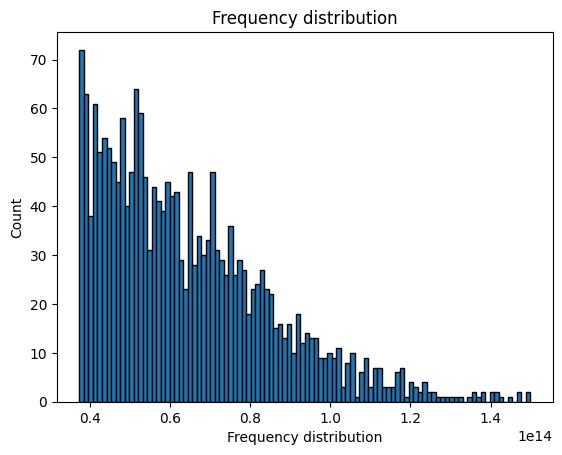

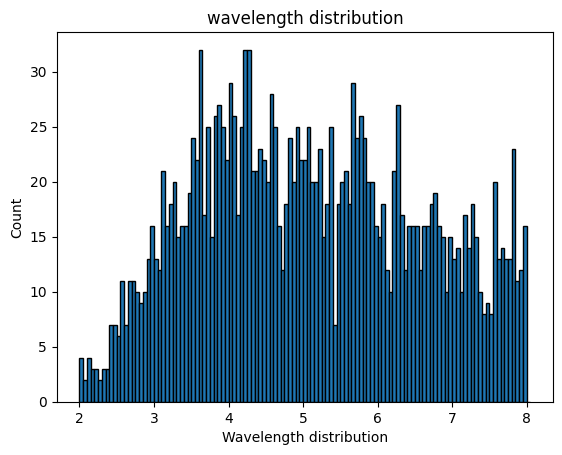

In [3]:
#Simulation params
num_sims = 10
freq_samples = 2000

#constraint due to material
lambda_min = 2
lambda_max = 8
constraint_min = td.constants.C_0/lambda_max
constraint_max = td.constants.C_0/lambda_min
print("Frequency range")
print('{:.2E}'.format(constraint_min),'{:.2E}'.format(constraint_max))
print("Wavelength range")
print(lambda_min,lambda_max)

#geometric parameters (um)
h1, h2, h3, h4 = 200e-3, 250e-3, 25e-3, 100e-3
p, w       = 3500e-3, 2700e-3
params = (h1,h2,h3,h4,p,w)
Lx, Ly, Lz = (p,p,13)
source_dist = 3

#Monitor specs
monitor_freqs = np.linspace(constraint_min, constraint_max, 200) #Hz
monitor_wvls = td.constants.C_0/monitor_freqs #um
print("Monitor range wavelength")
print(min(monitor_wvls),max(monitor_wvls))
print("Monitor range frequency")
print(min(monitor_freqs),max(monitor_freqs))

#Temperature
T = 650

#Spectrum generate
freqs = sample_blackbody_frequencies(T,freq_samples,constraint_min,constraint_max)
freq_range = (constraint_min,constraint_max)
freq0_all = 2.821439 * k * T / h

#Check
print("Frequency peak")
print('{:.2E}'.format(freq0_all))
print("Generated frequency range")
print('{:.2E}'.format(min(freqs)),'{:.2E}'.format(max(freqs)))


bin_width = 0.01 * (constraint_max - constraint_min)
bins = np.arange(constraint_min,constraint_max + bin_width, bin_width)
plt.hist(freqs, bins=bins, edgecolor='black')
plt.xlabel('Frequency distribution')
plt.ylabel('Count')
plt.title('Frequency distribution')
plt.show()

wavelengths_test = td.constants.C_0/freqs
bin_width = 0.05
bins = np.arange(lambda_min,lambda_max + bin_width, bin_width)
plt.hist(wavelengths_test, bins=bins, edgecolor='black')
plt.xlabel('Wavelength distribution')
plt.ylabel('Count')
plt.title('wavelength distribution')
plt.show()

### Make structure

In [4]:
def make_structure(num_pairs,params):
    #geometric parameters (um)
    h1, h2, h3, h4, p, w = params

    # --- materials ---
    Ni   = td.PoleResidue.from_file("Ni_0_12.json") #constraint wavelength
    SiO2 = td.Medium(permittivity=2.08, name="SiO2")

    # --- assemble layer specs as (name, thickness, medium, footprint) tuples ---
    layers = [
        ("substrate_Ni",  h1, Ni,   (td.inf, td.inf)),
        ("spacer_SiO2",   h2, SiO2, (td.inf, td.inf)),
    ]
    for i in range(1, num_pairs+1):
        layers.append((f"cube_Ni_{i}",    h3, Ni,   (w, w)))
        layers.append((f"cube_SiO2_{i}",  h4, SiO2, (w, w)))

    # --- compute total height and starting bottom z ---
    total_h = sum(th for (_, th, _, _) in layers)
    z_bot   = 0

    # --- build td.Structure list with correct centers ---
    stack = []
    for name, thickness, medium, (sx, sy) in layers:
        z_center = z_bot + thickness/2
        box = td.Box(center=(0, 0, z_center), size=(sx, sy, thickness))
        stack.append(td.Structure(geometry=box, medium=medium, name=name))
        z_bot += thickness

    return stack

### Incoherent Source

In [5]:
def make_source(num_source,freqs):
    sources = []
    for i in range(num_source):
        f = np.random.choice(freqs)
        source_planewave = td.PlaneWave(
        center=(0,0,(h1+h2) + 5*(h3+h4) + source_dist),
        source_time=td.GaussianPulse(freq0=f, fwidth=0.1*(constraint_max - constraint_min), phase=np.random.uniform(0,2*np.pi)),
        size=(td.inf,td.inf,0),
        direction="-",
        pol_angle=0,)
        sources.append(source_planewave)
    return sources

### Absorption sim

In [6]:
def make_absorption_sim(T):
    run_time = 10e-13 #fixed run time

    sim_size = (Lx,Ly,Lz + lambda_max) #fixed size

    # Grid specification
    grid_spec = td.GridSpec.auto(wavelength=0.2) #fixed_grid

    #Material specification
    stack = make_structure(5,params)
    
    #Sources
    #Spectrum generate
    freqs = sample_blackbody_frequencies(T,freq_samples,constraint_min,constraint_max)
    sources = make_source(1000,freqs)

    #Monitors
    reflection_monitor = td.FluxMonitor(
        center = (0, 0, h1 + h2 + 5*(h3+h4) + source_dist + 0.1),
        size = (Lx,Ly,0),
        freqs = monitor_freqs,
        name='ref')

    transmission_monitor = td.FluxMonitor(
        center = (0, 0, -1),
        size = (Lx,Ly,0),
        freqs = monitor_freqs,
        name='trans')

    boundary_spec = td.BoundarySpec(
    x=td.Boundary(minus=td.Periodic(), plus=td.Periodic()),
    y=td.Boundary(minus=td.Periodic(), plus=td.Periodic()),
    z=td.Boundary(minus=td.PML(num_layers=30), plus=td.PML(num_layers=30)),)

    sim = td.Simulation(
        center = (0, 0, 0),
        size = sim_size,
        grid_spec = grid_spec,
        structures = [],
        sources = sources,
        monitors = [reflection_monitor,transmission_monitor],
        run_time = run_time,
        boundary_spec = boundary_spec,
        normalize_index = None)
    return sim

sim_absorption = make_absorption_sim(T)

In [7]:
sim_absorption.plot_3d()

In [ ]:
sims = {}
for i in range(1, num_sims+1):
    sims[f"sim_{i}"] = make_absorption_sim(T)

# Build a Batch object.
batch = td.web.Batch(simulations=sims, verbose=True)

# Run all the simulations and get the results.
batch_results = batch.run(path_dir=f"data_absorption/{T}K")

Output()

14:40:57 UTC Started working on Batch containing 10 tasks.

14:41:10 UTC Maximum FlexCredit cost: 2.691 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

In [ ]:
data = []
for task_name, sim_data in batch_results.items():
  data.append(sim_data)

In [ ]:
flux_reflect = xr.concat([d['ref'].flux for d in data], dim='sim')
flux_reflect = np.array(flux_reflect.sum(dim='sim'))
flux_transmit = xr.concat([d['trans'].flux for d in data], dim='sim')
flux_transmit = -1*np.array(flux_transmit.sum(dim='sim'))

In [ ]:
plt.figure()
plt.plot(monitor_wvls, flux_transmit, label = "Transmission")
plt.xlabel("Wavelength (um)")
plt.ylabel("A,T,R")
plt.title("Absorption,Reflection,Transmission")
plt.legend()
plt.grid(True)
plt.show()